In [1]:
import pandas as pd
from common import collect_results, normalize_region_name, compute_quantiles
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
ROOT = Path("tpcc")

def get_matcher(system):
    def matcher(p: Path):   
        import re
        pattern = re.compile(r"tpcc-\d+-%s-terminals\d+-([\d-]+)" % system)
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        return {
            "suffix": str(match.group(1)),
        }
    
    return matcher

In [3]:
import json

def yb_matcher(p: Path):   
    import re
    pattern = re.compile(r"tpcc-(\d+)-yugabyte-terminals(\d+)")
    match = pattern.match(p.name)
    if not match:
        return None

    print("Found result:", p.name)
    return {
        "scalefactor": int(match.group(1)),
        "terminals": int(match.group(2)),
    }

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

def collect_yugabyte_results(path, renew_cache: bool):
    cache = path / "cache.csv"

    if renew_cache:
        cache.unlink(missing_ok=True)

    if cache.is_file():
        return pd.read_csv(cache)

    records = []
    for result_dir in path.iterdir():
        if not result_dir.is_dir():
            continue

        metadata = yb_matcher(result_dir)
        if metadata is None:
            continue

        for region_path in result_dir.iterdir():
            if not region_path.is_dir():
                continue
            record = {"path": region_path.as_posix(), "region": region_path.name, **metadata}

            raw_df = pd.read_csv(region_path / "oltpbench.csv", skiprows=2)
            raw_df["OperationLatency (microseconds)"] /= 1000

            transactions = raw_df["Transaction Name"].unique()
            for transaction in transactions:
                record.update(
                    compute_quantiles(
                        raw_df[raw_df["Transaction Name"] == transaction]["OperationLatency (microseconds)"],
                        remove_lower_outliers=True,
                        remove_upper_outliers=True,
                        suffix=f".{transaction}"
                    )
                )

            record.update(
                compute_quantiles(
                    raw_df["OperationLatency (microseconds)"],
                    remove_lower_outliers=True,
                    remove_upper_outliers=True
                )
            )

            output = json.loads((region_path / "json" / "output.json").read_text())

            runtime = output["TestConfiguration"]["runTimeInSecs"]
            record["time"] = runtime
            record["warmup"] = output["TestConfiguration"]["warmupTimeInSecs"]
            record["throughput"] = output["Results"]["throughput"]
            for lat in output["Latencies"]:
                if lat["Transaction"] != "All":
                    record[f"throughput.{lat['Transaction']}"] = lat["Count"] / runtime

            records.append(record)
    
    df = pd.DataFrame.from_records(records)
    df.to_csv(cache, index=False)

    return df

# Throughput


In [4]:
SYSTEMS = ["sunstorm", "aurora", "yugabyte", "cockroach"]
RENEW_CACHE = False

sunstorm_matcher = get_matcher("sunstorm")
sunstorm_throughput_df = collect_results(
    ROOT / "sunstorm",
    sunstorm_matcher,
    RENEW_CACHE,
)
normalize_region_name(sunstorm_throughput_df)

aurora_matcher = get_matcher("aurora")
aurora_throughput_df = collect_results(
    ROOT / "aurora",
    aurora_matcher,
    RENEW_CACHE,
)
normalize_region_name(aurora_throughput_df)


yugabyte_matcher = get_matcher("yugabyte")
yugabyte_throughput_df = collect_yugabyte_results(ROOT / "yugabyte", RENEW_CACHE)
normalize_region_name(yugabyte_throughput_df)

cockroach_matcher = get_matcher("cockroach")
cockroach_throughput_df = collect_results(
    ROOT / "cockroach",
    cockroach_matcher,
    RENEW_CACHE,
)
normalize_region_name(cockroach_throughput_df)

In [5]:
throughput_df = pd.concat([
    sunstorm_throughput_df.assign(system="sunstorm", terminals_rank=sunstorm_throughput_df["terminals"].rank(method="dense")),
    aurora_throughput_df.assign(system="aurora", terminals_rank=aurora_throughput_df["terminals"].rank(method="dense")),
    yugabyte_throughput_df.assign(system="yugabyte", terminals_rank=yugabyte_throughput_df["terminals"].rank(method="dense")),
    cockroach_throughput_df.assign(system="cockroach", terminals_rank=cockroach_throughput_df["terminals"].rank(method="dense")),
])
throughput_df

,path,region,suffix,rejected,rejected.NewOrder,rejected.Payment,aborted,aborted.NewOrder,unexpected,completed,...,deadlock.Delivery,rejected.StockLevel,unexpected.NewOrder,ood_index_page.StockLevel,ood_table.StockLevel,ood_tuple.StockLevel,other_aborts.StockLevel,deadlock.StockLevel,system,terminals_rank
0,tpcc/sunstorm/tpcc-100-sunstorm-terminals20-20...,1-us-east-1-0,20240517-143519,17.0,8.0,9.0,261.0,261.0,0.0,61379.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,3.0
1,tpcc/sunstorm/tpcc-100-sunstorm-terminals20-20...,3-ap-northeast-1-0,20240517-143519,134.0,83.0,51.0,207.0,207.0,0.0,44793.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,3.0
2,tpcc/sunstorm/tpcc-100-sunstorm-terminals20-20...,2-eu-west-1-0,20240517-143519,42.0,31.0,11.0,256.0,256.0,0.0,53040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,3.0
3,tpcc/sunstorm/tpcc-100-sunstorm-terminals60-20...,1-us-east-1-0,20240517-143519,1866.0,1097.0,769.0,575.0,575.0,0.0,135951.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,5.0
4,tpcc/sunstorm/tpcc-100-sunstorm-terminals60-20...,3-ap-northeast-1-0,20240517-143519,3700.0,2082.0,1617.0,528.0,528.0,0.0,111090.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,tpcc/cockroach/tpcc-10-cockroach-terminals10-2...,3-ap-northeast-1-0,20241127-135551,0.0,NaN,NaN,93.0,93.0,0.0,4739.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cockroach,2.0
38,tpcc/cockroach/tpcc-10-cockroach-terminals10-2...,2-eu-west-1-0,20241127-135551,0.0,NaN,NaN,114.0,114.0,0.0,5520.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cockroach,2.0
39,tpcc/cockroach/tpcc-100-cockroach-terminals40-...,1-us-east-1-0,20241127-150318,0.0,NaN,NaN,103.0,103.0,0.0,26583.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cockroach,4.0
40,tpcc/cockroach/tpcc-100-cockroach-terminals40-...,3-ap-northeast-1-0,20241127-150318,0.0,NaN,NaN,92.0,92.0,0.0,18560.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cockroach,4.0


## Scalefactor


In [6]:
throughput_df.pivot_table(
    index=["terminals_rank"], columns=["system", "scalefactor"], values="throughput", aggfunc="sum"
)

system               aurora                cockroach               \
scalefactor             10           100         10           100   
terminals_rank                                                      
1.0              139.448593   130.932060   26.299703    21.599851   
2.0              960.777134  1023.472787  288.295524   275.815061   
3.0             1264.437595  1445.483671  402.413614   585.629287   
4.0             1255.054702  1652.509837  469.728606  1113.272227   
5.0             1150.475827  1694.321240  484.529391  1628.020070   
6.0             1070.822328  1593.899501  466.163633  2099.119114   
7.0             1008.838633  1435.549001  471.094256  2557.301479   

system             sunstorm              yugabyte           
scalefactor             10           100      10       100  
terminals_rank                                              
1.0              140.532313   144.681540    34.44    28.55  
2.0             1335.872864  1408.820131   420.56   460.80  
3.0             1842.687935  2653.513394   456.71   900.60  
4.0             2507.356717  4804.184076   544.58  1602.29  
5.0             2926.209803  6195.821421   545.52  2540.50  
6.0             3207.204547  7397.430602   509.60  2293.55  
7.0             3476.415409  7924.252172   508.52  2059.01

## Throughput vs. Latency

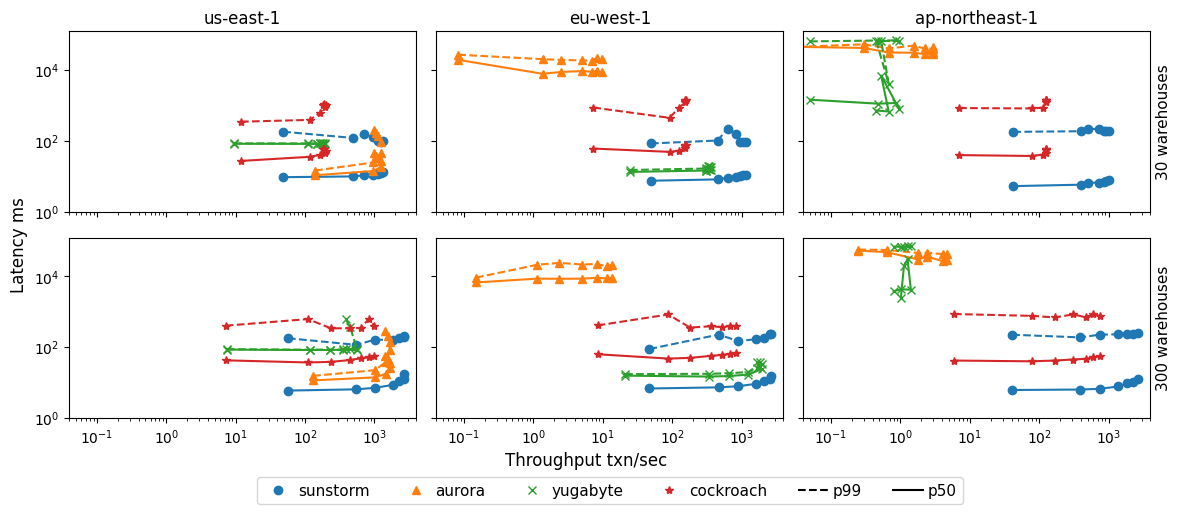

In [7]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

plt.rc('axes', labelsize=11) 
plt.rc('legend', fontsize=11)
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2, 3, figure=fig)

# for scalefactor in [1, 10, 100]:
for s, scalefactor in enumerate([10, 100]):
    scale_df = throughput_df[throughput_df["scalefactor"] == scalefactor]

    for r, region in enumerate(["1-us-east-1-0", "2-eu-west-1-0", "3-ap-northeast-1-0"]):
        region_df = scale_df[scale_df["region"] == region]
        region_name = {
            "1-us-east-1-0": "us-east-1",
            "2-eu-west-1-0": "eu-west-1",
            "3-ap-northeast-1-0": "ap-northeast-1",
        }[region]

        ax = plt.subplot(gs[s, r])

        for i, (system, marker) in enumerate(zip(SYSTEMS, ["o", "^", "x", "*"])):
            system_df = region_df[region_df["system"] == system].sort_values("terminals_rank")

            for y, linestyle in [("p50.NewOrder", "-"), ("p95.NewOrder", "--")]:               
                system_df.plot(
                    title=f"{region_name}",
                    x="throughput",
                    y=y,                   
                    style=f"{marker}{linestyle}C{i}",
                    rot=0,
                    logy=True,
                    logx=True,
                    xlim=(0.04, 4000),
                    ylim=(1, 120000),
                    ax=ax,
                )
            ax.get_legend().remove()
            ax.set_xlabel("")

        if r != 0:
            ax.get_yaxis().set_ticklabels([])
        if s == 0:
            ax.get_xaxis().set_ticklabels([])
        if s == 1:
            ax.set_title("")
        if r == 2:
            ax.set_ylabel(f"{scalefactor*3} warehouses")
            ax.yaxis.set_label_position("right")
        fig.supylabel("Latency ms", y=0.5)
fig.supxlabel("Throughput txn/sec", x=0.5, y=0.05)
#fig.suptitle("TPC-C NewOrder Transaction")
handles=[
    Line2D([0], [0], lw=0, marker='o', color='C0', markerfacecolor='C0', label='sunstorm'),
    Line2D([0], [0], lw=0, marker='^', color='C1', markerfacecolor='C1', label='aurora'),
    Line2D([0], [0], lw=0, marker='x', color='C2', markerfacecolor='C2', label='yugabyte'),
    Line2D([0], [0], lw=0, marker='*', color='C3', markerfacecolor='C3', label='cockroach'),
    Line2D([0], [0], color='k', linestyle='--', label='p99'),
    Line2D([0], [0], color='k', linestyle='-', label='p50'),

]
        
fig.legend(handles=handles, 
           title="",
           ncol=7,
           loc="upper center",
           handletextpad=0.3,
           bbox_to_anchor=(0.52,0.05)  # Adjust legend position if needed
          )
fig.tight_layout()
fig.savefig(f"tpcc-logx.pdf", bbox_inches="tight")

# Errors


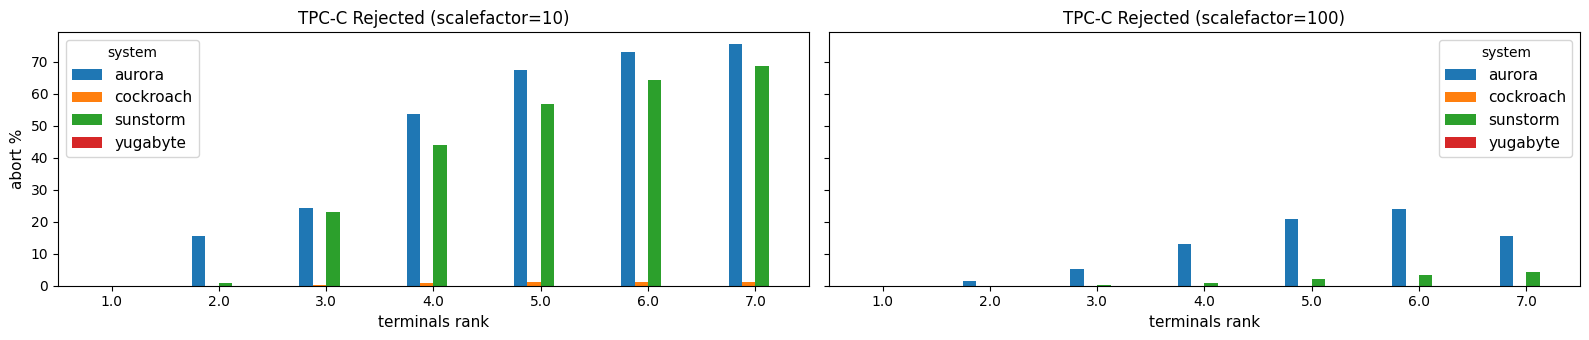

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3.5), sharex=True, sharey=True)

for i, scalefactor in enumerate([10, 100]):
    filtered = throughput_df[
        throughput_df["scalefactor"] == scalefactor
    ].sort_values("terminals_rank")
    rejected_df = filtered.pivot_table(index="terminals_rank", columns="system", values="rejected", aggfunc="sum")
    completed_df = filtered.pivot_table(index="terminals_rank", columns="system", values="completed", aggfunc="sum")
    ratio_df = rejected_df / (rejected_df + completed_df) * 100
    ratio_df.plot.bar(
        title=f"TPC-C Rejected (scalefactor={scalefactor})",
        xlabel="terminals rank",
        ylabel="abort %",
        ax=axes[i],
        rot=0,
    )

fig.tight_layout()


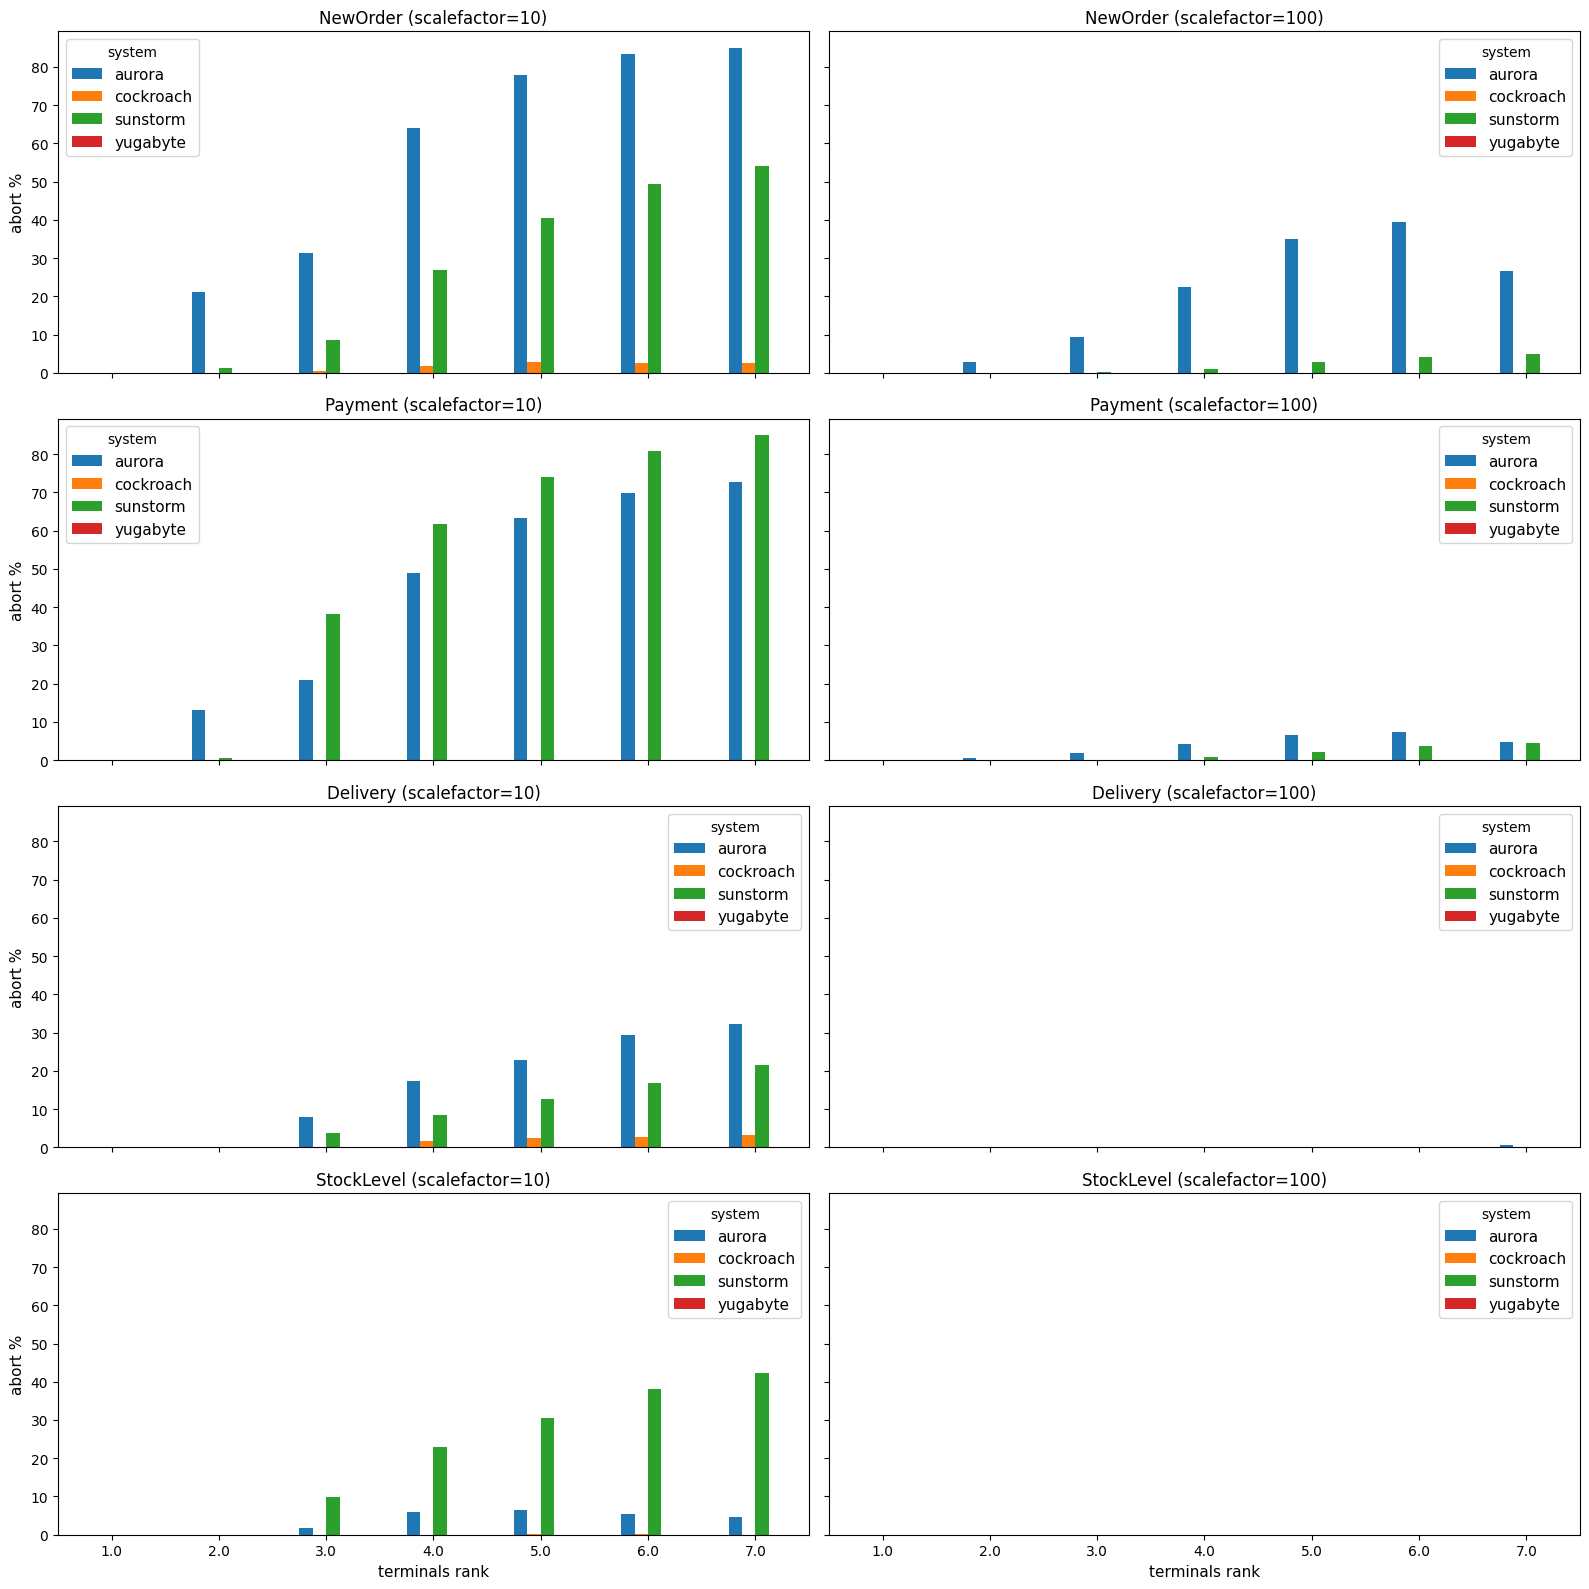

In [9]:
#transactions = ["NewOrder", "Payment", "OrderStatus", "Delivery", "StockLevel"]
transactions = ["NewOrder", "Payment", "Delivery", "StockLevel"]
fig, axes = plt.subplots(len(transactions), 2, figsize=(16, 16), sharex=True, sharey=True)

for row, transaction in enumerate(transactions):
    for col, scalefactor in enumerate([10, 100]):
        filtered = throughput_df[
            throughput_df["scalefactor"] == scalefactor
        ].sort_values("terminals_rank")
        rejected_df = filtered.pivot_table(index="terminals_rank", columns="system", values=f"rejected.{transaction}", aggfunc="sum")
        completed_df = filtered.pivot_table(index="terminals_rank", columns="system", values=f"completed.{transaction}", aggfunc="sum")
        ratio_df = rejected_df / (rejected_df + completed_df) * 100
        ratio_df.plot.bar(
            title=f"{transaction} (scalefactor={scalefactor})",
            xlabel="terminals rank",
            ylabel="abort %",
            ax=axes[row, col],
            rot=0,
        )

fig.tight_layout()
